In [34]:
import os
import ee
import geemap
from geemap import *
import geopandas as gpd
import geemap.colormaps as cm
import matplotlib.pyplot as plt

#ee.Authenticate()
ee.Initialize()
#geemap.update_package()

%matplotlib inline

In [35]:
Map = geemap.Map()

In [36]:
####################### GEOMETRIES AND POI's ####################################
#Import countries and filter 
countries = ee.FeatureCollection('users/giswqs/public/countries')
DE = countries.filter(ee.Filter.eq('NAME', 'Germany'))
NED = countries.filter(ee.Filter.eq('NAME', 'Netherlands'))
#Map.addLayer(DE, {}, 'DE')
#Map.addLayer(NED, {}, 'NED')

#POI Lobith
a_lon =  6.101863382807894
a_lat = 51.84911543823371
Lobith = ee.Geometry.Point(a_lon, a_lat)

imp_main = 'C:/Users/stefs/Desktop/Thesis/GIS/Mainz_poly.shp'
MAIN = geemap.shp_to_ee(imp_main)

#Map.addLayer(Lobith_Poly, {}, "POLY")
#Import countries and filter 
countries = ee.FeatureCollection('users/giswqs/public/countries')
DE = countries.filter(ee.Filter.eq('NAME', 'Germany'))
NED = countries.filter(ee.Filter.eq('NAME', 'Netherlands'))

In [37]:
#INPUT
#BASE
BOUNDS = MAIN
POLYGON = MAIN
POINT = Lobith
START_DATE = '2017-01-01'
END_DATE = '2020-12-31'
lon = 8.290818
lat = 49.994658

#CLOUDMASKING
AOI = POINT
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 50

#OUTPUTS
out_name = 'SSC_Lobith21STAT.csv'

In [38]:
#Making clips of SSC maps
def clp (image):
    return image.clip(BOUNDS).copyProperties(image,['PRODUCT_ID', 'IMAGE_DATE'])


In [39]:
#Water masking to only show permanent water
Watermask = ee.ImageCollection("ESA/WorldCover/v100").first().eq(80).selfMask().clip(BOUNDS)
Clip_mask = Watermask.clip(BOUNDS)
Map.addLayer(Watermask, {}, "Water")

def mask (image):
    return image.mask(Watermask)

In [40]:
#CALCULATE SSC
#B2 = BLUE ;B3 = GREEN; B4 = RED; B5 = REDEDGE1
def CalculateSSC(image):
    selected = image.select('B3', 'B4', 'B2', 'B1', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12')
    expression = '(133.89*((b(4)/b(0))**2))-(142.23*(b(4)/b(0)))+49.116'
    SSC = selected.expression(expression).rename('SSC')
    return selected.addBands(SSC)

#133.89x2 - 142.23x + 49.116

In [41]:
s2_sr_col = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(START_DATE, END_DATE).filterBounds(BOUNDS).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 80).map(clp)

In [42]:
#FUNCTIONS TO COMBINE CLOUDLESS WITH DATASET
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(START_DATE, END_DATE).filterBounds(BOUNDS).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 80).map(clp)

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(BOUNDS)
        .filterDate(START_DATE, END_DATE))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [43]:
#BUILD COLLECTION ACCORDING TO PARAMETERS 
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
#s2_sr_cld_col

In [44]:
#FUNCTION FOR CLOUD PROBABILITY LAYER
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

In [45]:
#FUNCTION FOR CLOUD SHADOW COMPONENT
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [46]:
#FINAL MASK WITH CLOUDS AND CLOUD SHADOWS
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [47]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [48]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

In [49]:
#DISPLAY
#s2_sr_cld_col_eval_disp = s2_sr_cld_col.map(add_cld_shdw_mask)

#display_cloud_layers(s2_sr_cld_col_eval_disp)

In [50]:
#FUNCTION TO APPLY CLOUD MASK IN EACH IMAGE
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [51]:
#COLLECTION PROCESS
s2_sr = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask))

SSCcollection=s2_sr.map(mask).map(CalculateSSC)

In [52]:
vis_params = {"bands": ['SSC'], "min": 20, "max": 150, 'palette': ['#0000FF','#8A2BE2','#FF4040','#FF6103','#76EE00','#00FA9A']}

'00FFFF', '0000FF'
'4286f4','41f471','f441cd','f1f441'

image = ee.Image(SSCcollection.first())
Map.addLayer(image, vis_params, 'First image')
Map.setCenter(lon, lat, 13)


Text(0.5, 1.0, 'SSC-Mainz')

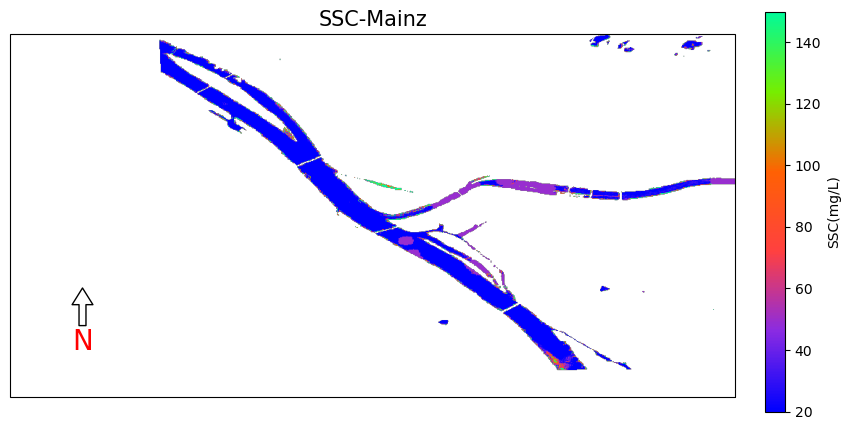

In [53]:
w = 0.08
h = 0.04

region = [lon-w, lat-h, lon+w, lat+h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
#cartoee.add_gridlines(ax, interval=[0.1, 0.1], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "red",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center"
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 5, 
    "xy": (0.1, 0.05), 
    "linewidth": 3,
    "fontsize": 20,
    "color": "red",
    "unit": "km",
    "ha": "center",
    "va": "bottom"    
}

# add colorbar
color_bar_dict = { 
             "loc":"right", 
             "cmap":'gray', 
             "discrete":False, 
             "label":"SSC(mg/L)"}

cartoee.add_colorbar(ax, vis_params, **color_bar_dict)


#cartoee.add_colorbar(ax, 
#             vis_params, 
#             loc="right", 
#             cmap='gray', 
#             discrete=False, 
#             label= 'SSC(mg/L)')

#cartoee.add_scale_bar(ax, **scale_bar_dict)
#cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label = 'SSC-Mainz', fontsize=15)

#show()


In [54]:
cartoee.get_image_collection_gif(
    ee_ic=SSCcollection,
    out_dir=os.path.expanduser("~/Downloads/timelapse"),
    out_gif="animation.gif",
    vis_params=vis_params,
    region= region,
    fps=1,
    mp4=True,
    grid_interval= None,
    plot_title="Mainz-SSC",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=500,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    verbose=True,
)

GIF saved to C:\Users\stefs\Downloads\timelapse\animation.gif
Installing opencv-python ...
MP4 saved to C:\Users\stefs\Downloads\timelapse\animation.mp4
